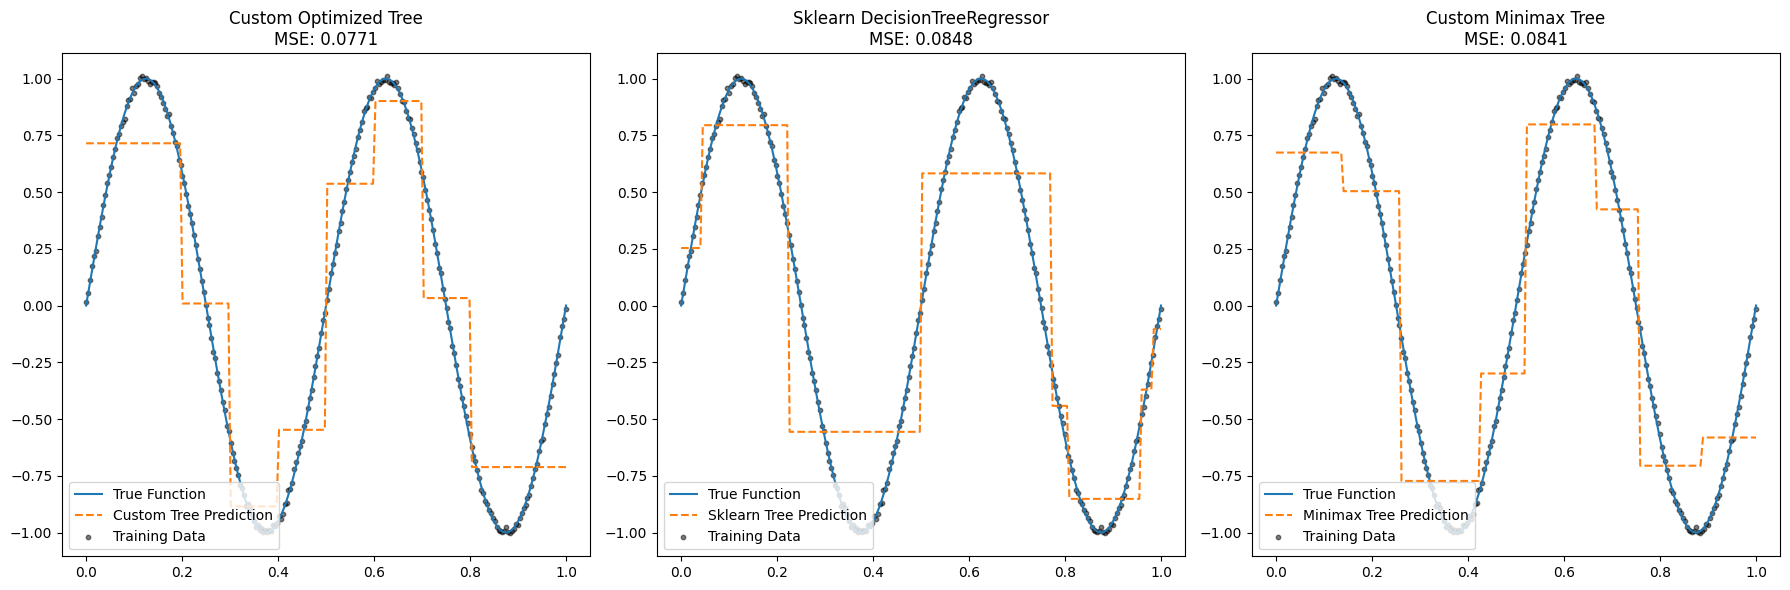

Custom tree prediction MSE: 0.0771
Sklearn DecisionTreeRegressor MSE: 0.0848
Minimax tree prediction MSE: 0.0841


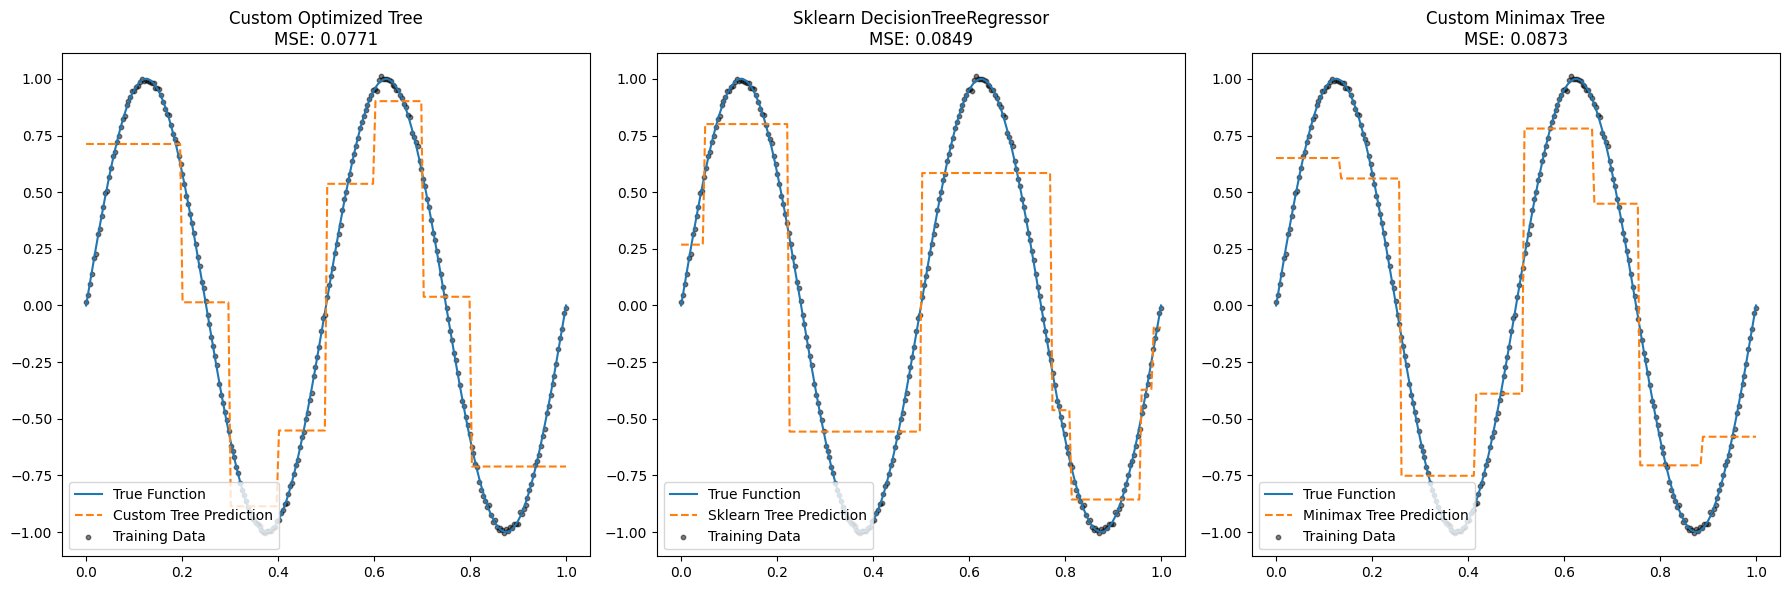

Custom tree prediction MSE: 0.0771
Sklearn DecisionTreeRegressor MSE: 0.0849
Minimax tree prediction MSE: 0.0873


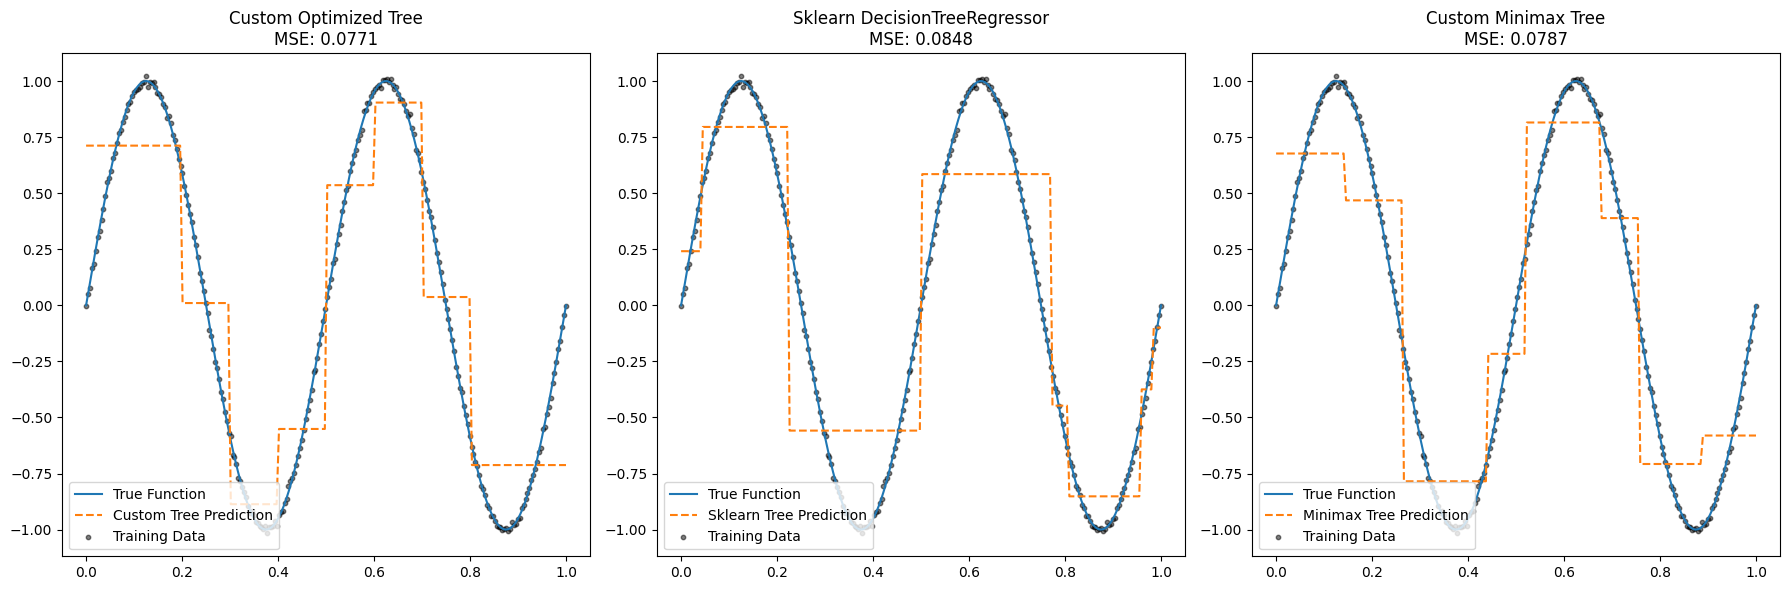

Custom tree prediction MSE: 0.0771
Sklearn DecisionTreeRegressor MSE: 0.0848
Minimax tree prediction MSE: 0.0787


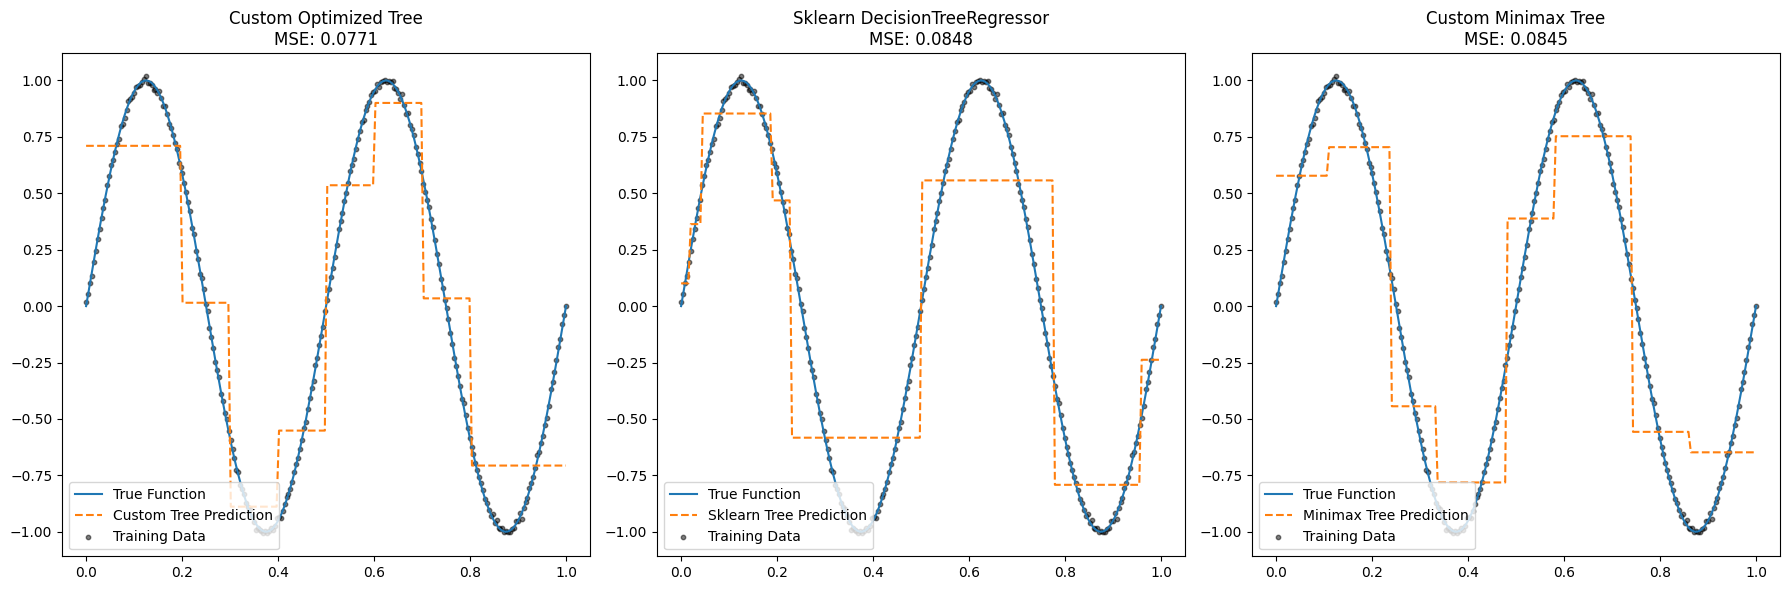

Custom tree prediction MSE: 0.0771
Sklearn DecisionTreeRegressor MSE: 0.0848
Minimax tree prediction MSE: 0.0845


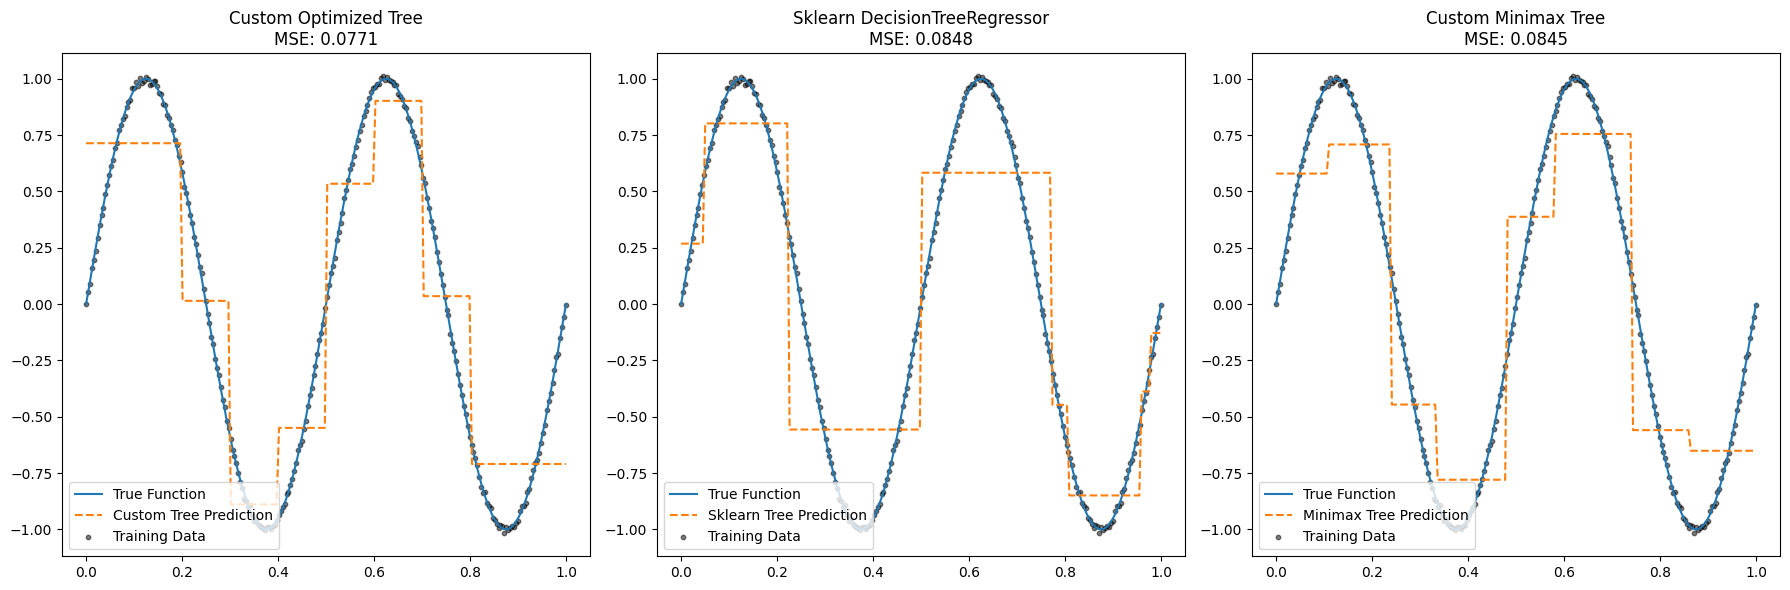

Custom tree prediction MSE: 0.0771
Sklearn DecisionTreeRegressor MSE: 0.0848
Minimax tree prediction MSE: 0.0845


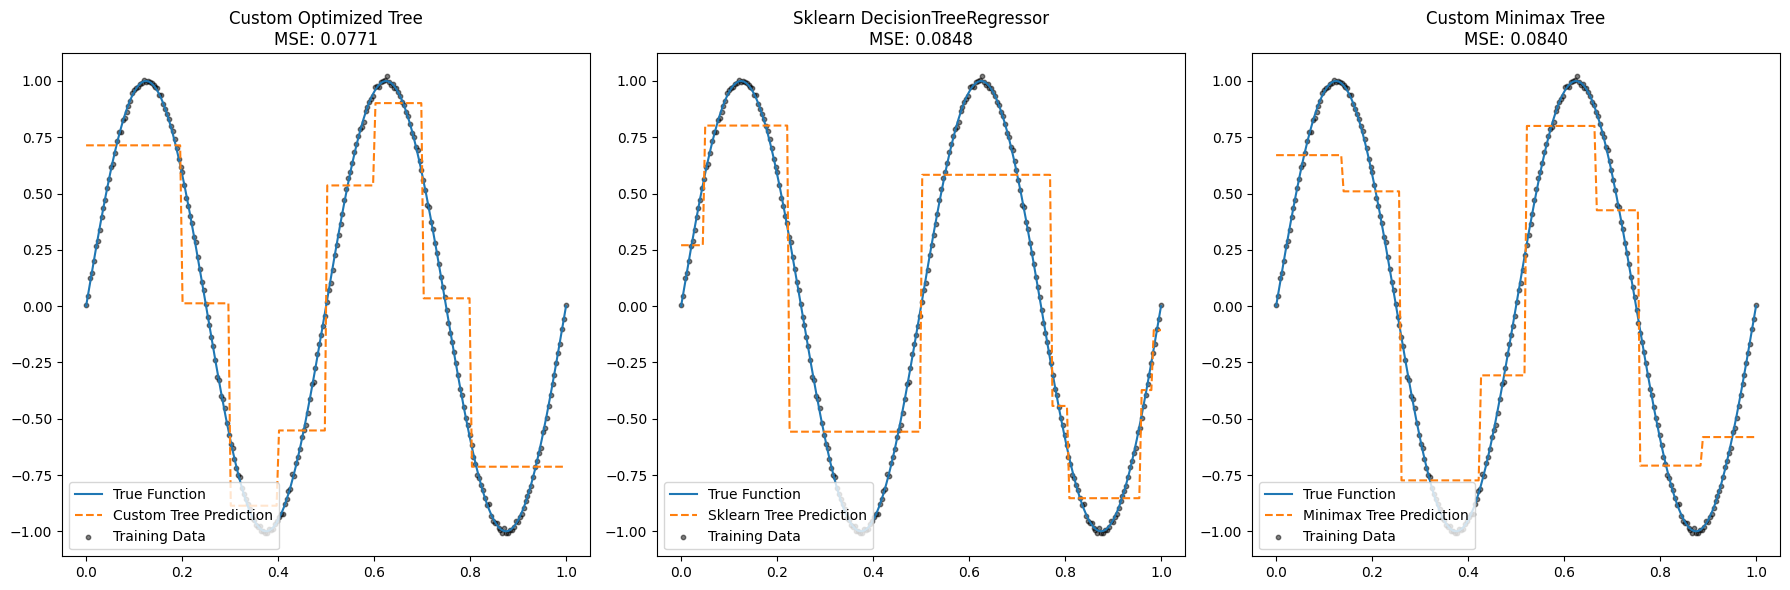

Custom tree prediction MSE: 0.0771
Sklearn DecisionTreeRegressor MSE: 0.0848
Minimax tree prediction MSE: 0.0840


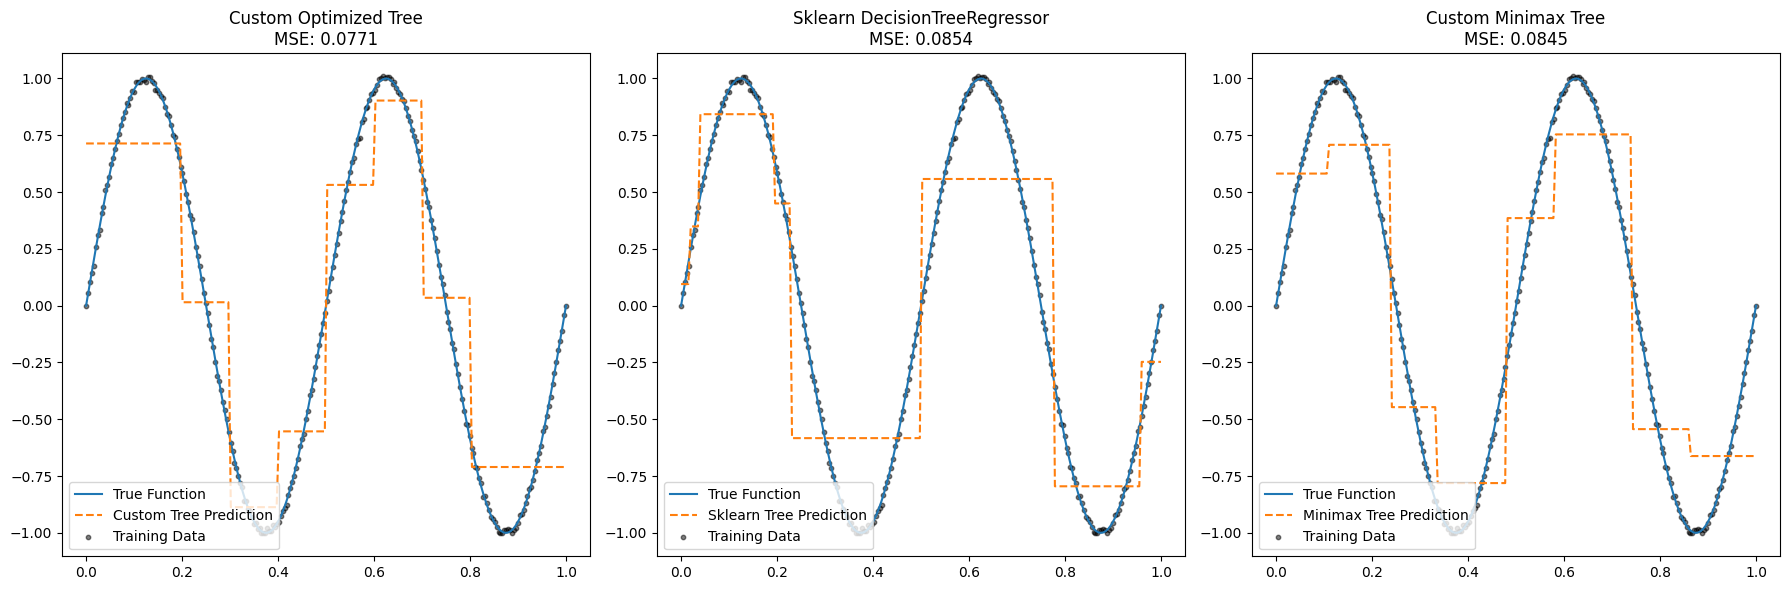

Custom tree prediction MSE: 0.0771
Sklearn DecisionTreeRegressor MSE: 0.0854
Minimax tree prediction MSE: 0.0845


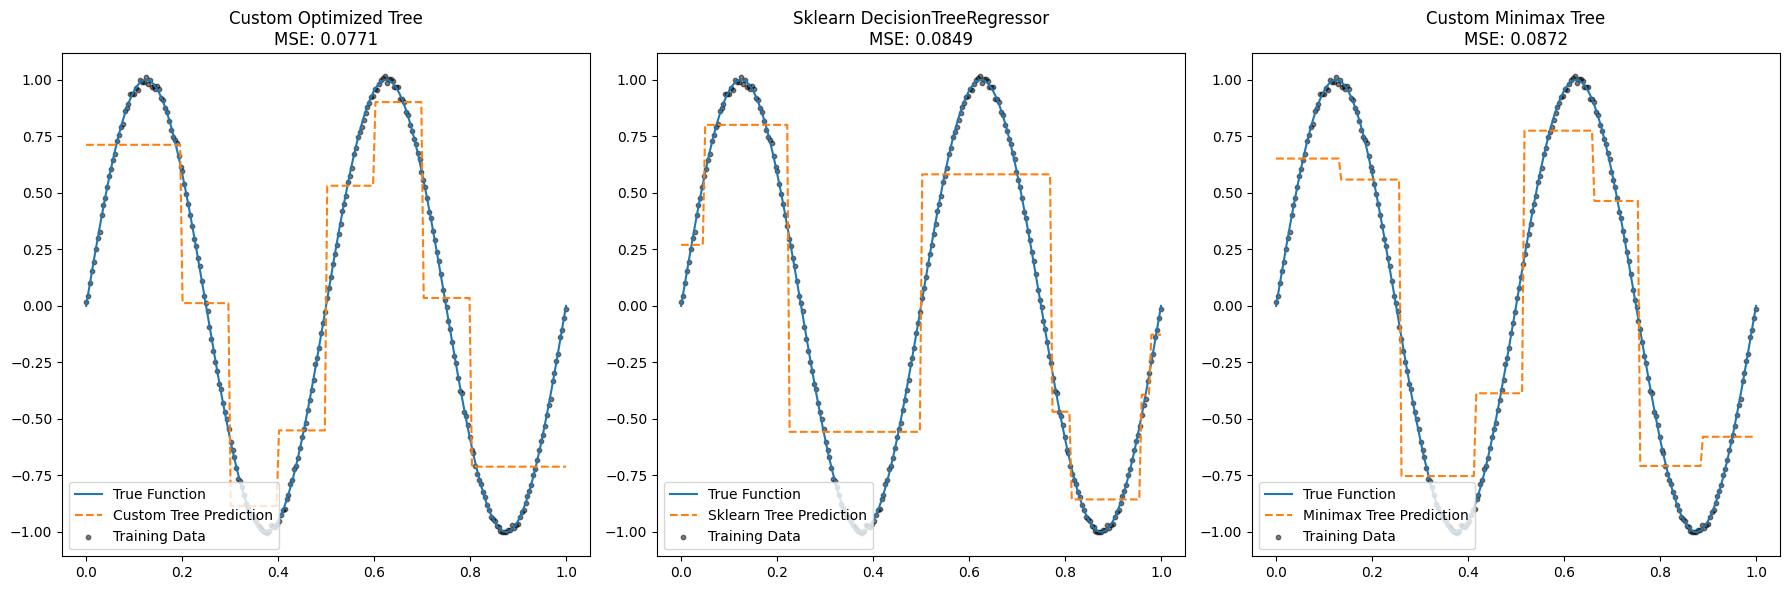

Custom tree prediction MSE: 0.0771
Sklearn DecisionTreeRegressor MSE: 0.0849
Minimax tree prediction MSE: 0.0872


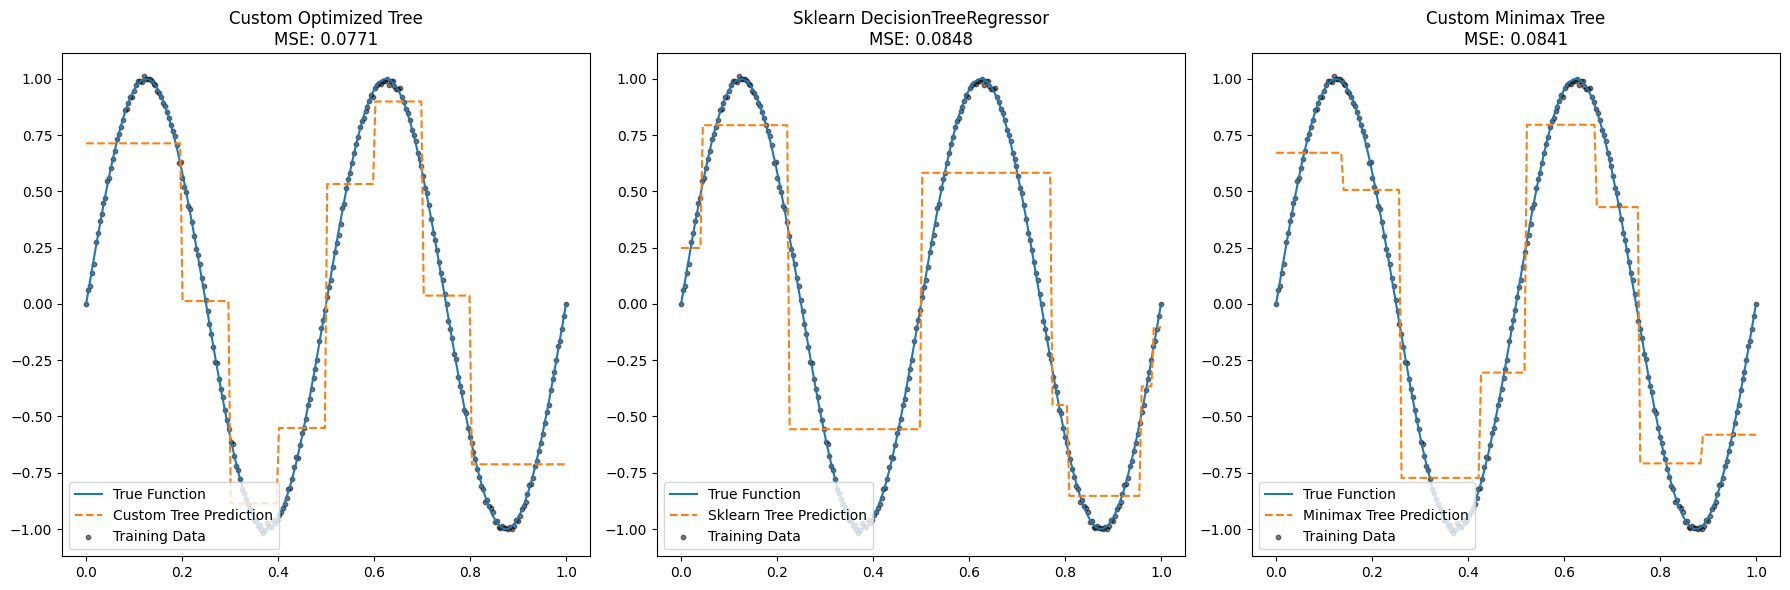

Custom tree prediction MSE: 0.0771
Sklearn DecisionTreeRegressor MSE: 0.0848
Minimax tree prediction MSE: 0.0841


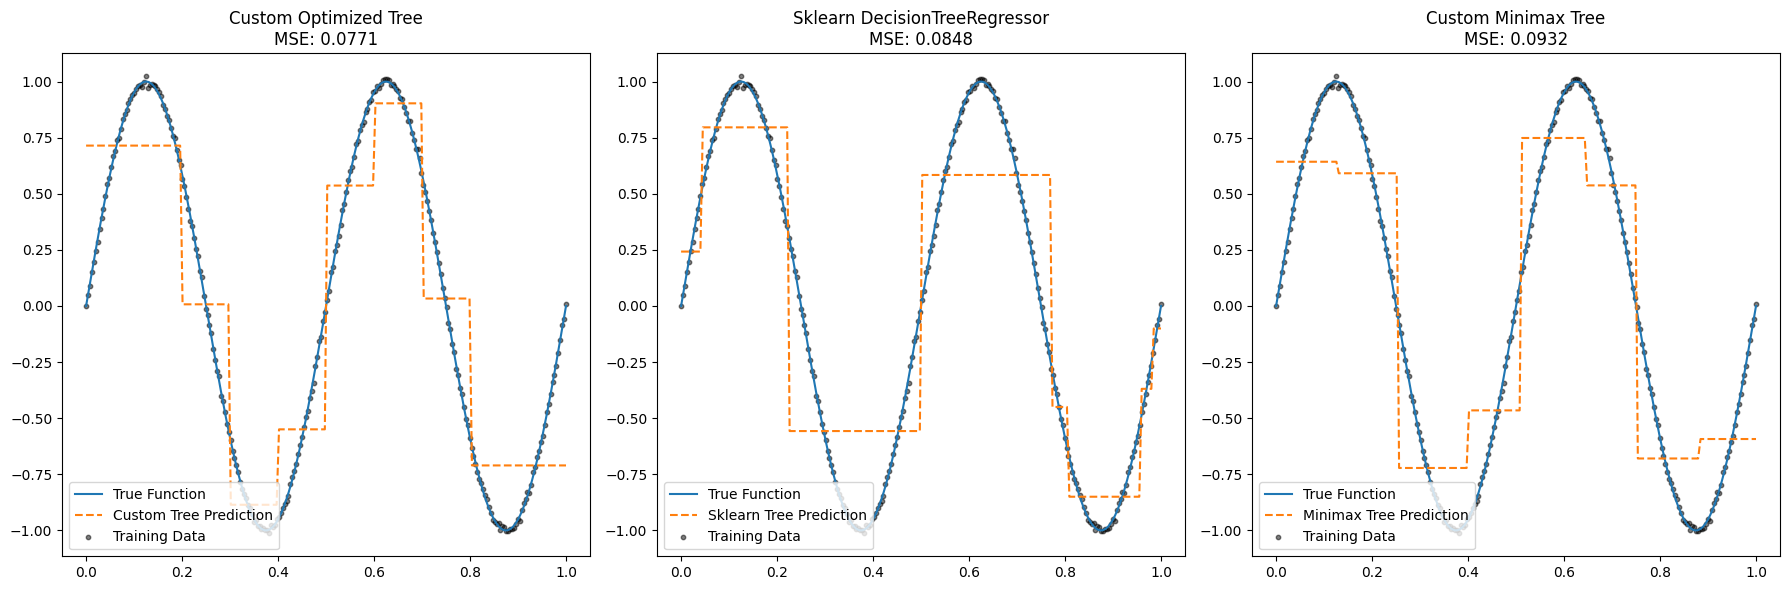

Custom tree prediction MSE: 0.0771
Sklearn DecisionTreeRegressor MSE: 0.0848
Minimax tree prediction MSE: 0.0932


In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor as SklearnDecisionTreeRegressor
# Generate 1D example data
np.random.seed(122)
def f_truth(X, noise_var=0.01):
    n_samples = X.shape[0]
    return np.sin(4 * np.pi * X).ravel() + noise_var * np.random.randn(n_samples)

class myDecisionTreeRegressor:
    def __init__(self, min_samples_split=2, max_depth=float('inf'), error_method='variance', cyclic_padding=0, loss_norm=2):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None
        self.error_method = error_method
        self.cyclic_padding = cyclic_padding
        self.loss_norm = loss_norm

    class Node:
        def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None, data=None, targets=None):
            self.feature_index = feature_index
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value
            self.data = data
            self.targets = targets
            if self.left == None and self.right == None:
                self.is_leaf = True
            else:
                self.is_leaf = False

    def fit(self, X, y, depth=0):
        if len(X) < self.min_samples_split or depth >= self.max_depth:
            node = self.Node(value=y.mean(), data=X, targets=y)
            node.is_leaf = True
            return node

        if self.error_method == 'cyclic_minimax':
            best_split = self.cyclic_minimax_split(X, y, depth)
        else:
            best_split = self.find_best_split(X, y)

        best_feature, best_threshold = best_split
        if best_split is None or best_threshold is None:
            node = self.Node(value=y.mean(), data=X, targets=y)
            node.is_leaf = True
            return node
        left_indices = X[:, best_feature] <= best_threshold
        right_indices = ~left_indices
        left_subtree = self.fit(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self.fit(X[right_indices], y[right_indices], depth + 1)
        return self.Node(feature_index=best_feature, threshold=best_threshold, left=left_subtree, right=right_subtree, data=X, targets=y)

    def find_best_split(self, X, y):
        num_features = X.shape[1]
        min_error = float('inf')
        best_feature = None
        best_threshold = None

        for feature_index in range(num_features):
            index, threshold, error = self.evaluate_splits(X, y, feature_index)
            if error < min_error:
                min_error = error
                best_feature = feature_index
                best_threshold = threshold

        return best_feature, best_threshold

    def cyclic_minimax_split(self, X, y, depth):
        num_features = X.shape[1]
        feature_index = (self.cyclic_padding+depth) % num_features
        ###print('cyclic index ',feature_index)
        best_feature, best_threshold, _ = self.evaluate_splits(X, y, feature_index)
        best_feature = feature_index
        return best_feature, best_threshold

    def evaluate_splits(self, X, y, feature_index):
        if self.error_method == 'median_X':
            threshold = np.median(X[:, feature_index])
            left_indices = X[:, feature_index] <= threshold
            right_indices = ~left_indices
            min_error = 0
            best_threshold = threshold
            return feature_index, (best_threshold, min_error)
        elif self.error_method == 'median_y':
            median_y_value = np.median(y)
            index = np.argsort(np.abs(y - median_y_value))[0]
            threshold = X[index, feature_index]
            left_indices = X[:, feature_index] <= threshold
            right_indices = ~left_indices
            min_error = 0
            best_threshold = threshold
            return feature_index, (best_threshold, min_error)
        else:
            thresholds = np.unique(X[:, feature_index])
            min_error = float('inf')
            best_threshold = None
            for threshold in thresholds:
                left_indices = X[:, feature_index] <= threshold
                right_indices = ~left_indices
                error = self.calculate_error(y, left_indices, right_indices) 
                if error < min_error:
                    min_error = error
                    best_threshold = threshold
            return feature_index, best_threshold, min_error
    def calculate_p_norm_error(self, y, indices, p):
        if p == np.inf:
            # Max norm (L-infinity) handling
            return np.max(np.abs(y[indices] - np.mean(y[indices])))
        else:
            # General p-norm
            return np.sum(np.abs(y[indices] - np.mean(y[indices])) ** p)
    def calculate_error(self, y, left_indices, right_indices):
        if sum(left_indices)<=1 or sum(left_indices) is None:
            return np.inf
        if sum(right_indices)<=1 or sum(right_indices) is None:
            return np.inf 
        left_error = right_error = 0
        if self.error_method == 'variance':
            if self.loss_norm == 2:
                # Special case for standard variance (quadratic norm)
                left_error = ((y[left_indices] - y[left_indices].mean()) ** 2).sum()
                right_error = ((y[right_indices] - y[right_indices].mean()) ** 2).sum()
            else:
                # Generic p-norm
                left_error = self.calculate_p_norm_error(y, left_indices, self.loss_norm)
                right_error = self.calculate_p_norm_error(y, right_indices, self.loss_norm)
            return left_error+right_error
        elif self.error_method == 'minimax' or self.error_method == 'cyclic_minimax':
            if self.loss_norm == 2:
                # Special case for standard variance (quadratic norm)
                left_error = ((y[left_indices] - y[left_indices].mean()) ** 2).sum()
                right_error = ((y[right_indices] - y[right_indices].mean()) ** 2).sum()
            else:
                # Generic p-norm
                left_error = self.calculate_p_norm_error(y, left_indices, self.loss_norm)
                right_error = self.calculate_p_norm_error(y, right_indices, self.loss_norm)
            return max(left_error, right_error)
        elif self.error_method == 'weighted_variance':
            left_error = sum(left_indices) * ((y[left_indices] - y[left_indices].mean()) ** 2).sum()
            right_error = sum(right_indices) * ((y[right_indices] - y[right_indices].mean()) ** 2).sum()
            return left_error+right_error
        return left_error + right_error

    def predict(self, X):
        predictions = [self._predict_one(x, self.root) for x in X]
        return predictions

    def _predict_one(self, x, node):
        while not node.is_leaf:
            if x[node.feature_index] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value
    
    def prune(self, node=None):
        if node is None:
            node = self.root

        if node.is_leaf:
            return

        if node.left.is_leaf and node.right.is_leaf:
            original_error = self.node_error(node)
            node.is_leaf = True
            node.value = node.targets.mean()
            pruned_error = self.node_error(node)
            complexity_alpha = 0.1
            original_complexity = original_error + complexity_alpha*self.count_leaves()
            pruned_complexity = pruned_error + complexity_alpha*self.count_leaves()
            if pruned_complexity > original_complexity:
                node.is_leaf = False
                node.value = None
            else:
                node.left = None
                node.right = None

        if not node.is_leaf:
            self.prune(node.left)
            self.prune(node.right)

    def node_error(self, node):
        if node.is_leaf:
            return ((node.targets - node.value) ** 2).mean()
        return ((self.predict(node.data) - node.targets) ** 2).mean()
    
    def print_tree(self, node=None, depth=0):
        if node is None:
            node = self.root

        if node.is_leaf:
            print(f"{'    ' * depth}Leaf: Predict = {node.value:.4f}")
        else:
            print(f"{'    ' * depth}Node: X[{node.feature_index}] <= {node.threshold:.4f}, "
                  f"Error = {self.node_error(node):.4f}")
            self.print_tree(node.left, depth + 1)
            self.print_tree(node.right, depth + 1)

    def count_leaves(self, node=None):
        if node is None:
            node = self.root
        if node.is_leaf:
            return 1
        else:
            return self.count_leaves(node.left) + self.count_leaves(node.right)

def custom_tree_predict(X_grid, s1, s2, s3, s4, s5, s6, s7):
    predictions = np.zeros(X_grid.shape[0])

    # Form the partitions based on the split points
    left_mask = X_grid.ravel() < s1
    right_mask = ~left_mask

    left_left_mask = (X_grid.ravel() < s2) & left_mask
    left_right_mask = ~left_left_mask & left_mask

    left_left_left_mask = (X_grid.ravel() < s4) & left_left_mask
    left_left_right_mask = ~left_left_left_mask & left_left_mask

    left_right_left_mask = (X_grid.ravel() < s5) & left_right_mask
    left_right_right_mask = ~left_right_left_mask & left_right_mask

    right_left_mask = (X_grid.ravel() < s3) & right_mask
    right_right_mask = ~right_left_mask & right_mask

    right_left_left_mask = (X_grid.ravel() < s6) & right_left_mask
    right_left_right_mask = ~right_left_left_mask & right_left_mask

    right_right_left_mask = (X_grid.ravel() < s7) & right_right_mask
    right_right_right_mask = ~right_right_left_mask & right_right_mask

    # Assign predictions to each partition
    predictions[left_left_left_mask] = np.mean(y[(X.ravel() < s1) & (X.ravel() < s2) & (X.ravel() < s4)])
    predictions[left_left_right_mask] = np.mean(y[(X.ravel() < s1) & (X.ravel() < s2) & (X.ravel() >= s4)])

    predictions[left_right_left_mask] = np.mean(y[(X.ravel() < s1) & (X.ravel() >= s2) & (X.ravel() < s5)])
    predictions[left_right_right_mask] = np.mean(y[(X.ravel() < s1) & (X.ravel() >= s2) & (X.ravel() >= s5)])

    predictions[right_left_left_mask] = np.mean(y[(X.ravel() >= s1) & (X.ravel() < s3) & (X.ravel() < s6)])
    predictions[right_left_right_mask] = np.mean(y[(X.ravel() >= s1) & (X.ravel() < s3) & (X.ravel() >= s6)])

    predictions[right_right_left_mask] = np.mean(y[(X.ravel() >= s1) & (X.ravel() >= s3) & (X.ravel() < s7)])
    predictions[right_right_right_mask] = np.mean(y[(X.ravel() >= s1) & (X.ravel() >= s3) & (X.ravel() >= s7)])

    return predictions
# Define the objective function as the sum of MSEs
def objective_function(splits):
    s1, s2, s3, s4, s5, s6, s7 = splits
    #total_mse = 0
    total_mse = np.mean( ( y - custom_tree_predict(X, s1, s2, s3, s4, s5, s6, s7) )**2)
    return total_mse


# Main loop
for iii in range(10):
    # Generate data
    n_samples = 250 
    X = np.linspace(0, 1, n_samples).reshape(-1, 1)
    np.random.seed(iii)
    y = f_truth(X, 0.01)
    X_grid = np.linspace(0, 1, 200).reshape(-1, 1)
    y_grid_true = f_truth(X_grid, 0)

    # Optimize custom tree (from your original code)
    initial_splits = [0.5, 0.3, 0.7, 0.2, 0.4, 0.6, 0.8]
    bounds = [(0, 1)] * 7
    constraints = [
        {'type': 'ineq', 'fun': lambda splits: splits[0] - splits[1]},
        # ... (other constraints)
    ]
    result = minimize(objective_function, initial_splits, method='SLSQP', bounds=bounds, constraints=constraints)
    s1_opt, s2_opt, s3_opt, s4_opt, s5_opt, s6_opt, s7_opt = result.x

    # Adjust split points (from your original code)
    def find_closest_point(X, split_point):
        return X[np.argmin(np.abs(X - split_point))]
    
    s1_opt, s2_opt, s3_opt, s4_opt, s5_opt, s6_opt, s7_opt = [find_closest_point(X, s) for s in [s1_opt, s2_opt, s3_opt, s4_opt, s5_opt, s6_opt, s7_opt]]

    # Predict using custom tree
    y_pred_custom = custom_tree_predict(X_grid, s1_opt, s2_opt, s3_opt, s4_opt, s5_opt, s6_opt, s7_opt)

    # Train and predict using sklearn's DecisionTreeRegressor
    sklearn_tree = SklearnDecisionTreeRegressor(max_depth=3)
    sklearn_tree.fit(X, y)
    y_pred_sklearn = sklearn_tree.predict(X_grid)

    # Train and predict using your custom DecisionTreeRegressor with minimax
    minimax_tree = myDecisionTreeRegressor(min_samples_split=2, max_depth=3,error_method='cyclic_minimax',loss_norm=2)
    minimax_tree.root = minimax_tree.fit(X, y)
    y_pred_minimax = minimax_tree.predict(X_grid)

    # Calculate MSE for all methods
    mse_custom_grid = np.mean((y_grid_true - y_pred_custom) ** 2)
    mse_sklearn_grid = np.mean((y_grid_true - y_pred_sklearn) ** 2)
    mse_minimax_grid = np.mean((y_grid_true - y_pred_minimax) ** 2)

    # Visualize results
    plt.figure(figsize=(18, 6))

    # Custom Tree
    plt.subplot(1, 3, 1)
    plt.plot(X_grid, y_grid_true, label='True Function')
    plt.plot(X_grid, y_pred_custom, label='Custom Tree Prediction', linestyle='--')
    plt.scatter(X, y, c='black', alpha=0.5, s=10, label='Training Data')
    plt.title(f'Custom Optimized Tree\nMSE: {mse_custom_grid:.4f}')
    plt.legend(loc='lower left')

    # Sklearn Tree
    plt.subplot(1, 3, 2)
    plt.plot(X_grid, y_grid_true, label='True Function')
    plt.plot(X_grid, y_pred_sklearn, label='Sklearn Tree Prediction', linestyle='--')
    plt.scatter(X, y, c='black', alpha=0.5, s=10, label='Training Data')
    plt.title(f'Sklearn DecisionTreeRegressor\nMSE: {mse_sklearn_grid:.4f}')
    plt.legend(loc='lower left')

    # Minimax Tree
    plt.subplot(1, 3, 3)
    plt.plot(X_grid, y_grid_true, label='True Function')
    plt.plot(X_grid, y_pred_minimax, label='Minimax Tree Prediction', linestyle='--')
    plt.scatter(X, y, c='black', alpha=0.5, s=10, label='Training Data')
    plt.title(f'Custom Minimax Tree\nMSE: {mse_minimax_grid:.4f}')
    plt.legend(loc='lower left')

    plt.tight_layout()
    plt.show()

    print(f"Custom tree prediction MSE: {mse_custom_grid:.4f}")
    print(f"Sklearn DecisionTreeRegressor MSE: {mse_sklearn_grid:.4f}")
    print(f"Minimax tree prediction MSE: {mse_minimax_grid:.4f}")

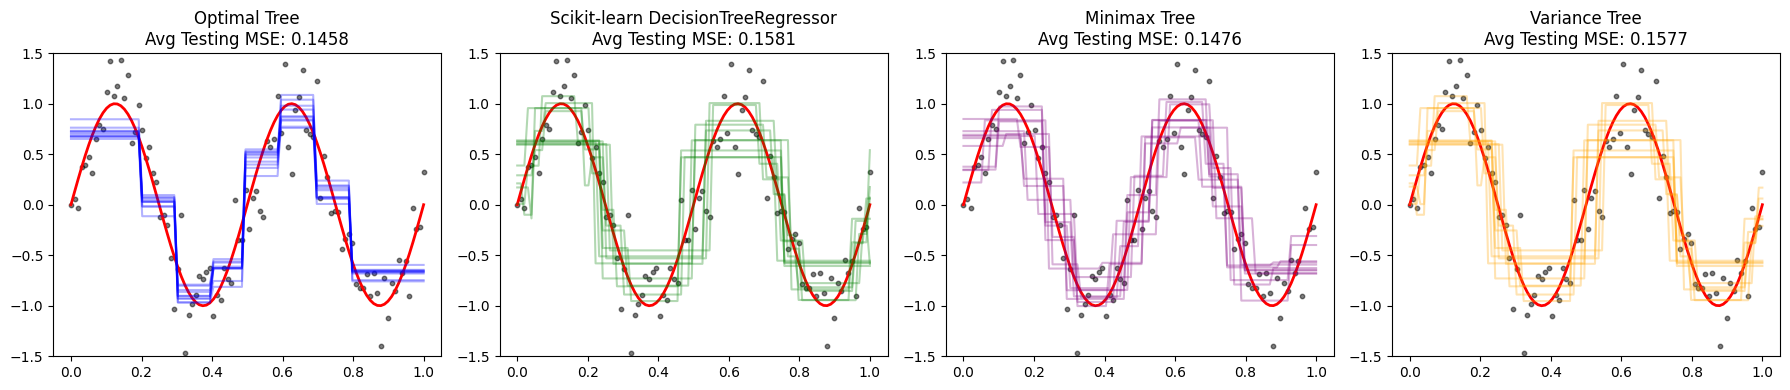

Average Custom tree prediction MSE: 0.1458
Average Sklearn DecisionTreeRegressor MSE: 0.1581
Average Minimax tree prediction MSE: 0.1476
Average Variance tree prediction MSE: 0.1577


In [2]:
# Initialize lists to store results
custom_predictions = []
sklearn_predictions = []
variance_predictions = []
minimax_predictions = []
custom_mses = []
sklearn_mses = []
variance_mses = []
minimax_mses = []

# Main loop
n_iterations = 10
for iii in range(n_iterations):
    # Generate data
    n_samples = 100 
    X = np.linspace(0, 1, n_samples).reshape(-1, 1)
    np.random.seed(iii)
    y = f_truth(X, 0.25)
    X_grid = np.linspace(0, 1, 100).reshape(-1, 1)
    y_grid_true = f_truth(X_grid, 0.25)

    # Optimize custom tree
    initial_splits = [0.5, 0.3, 0.7, 0.2, 0.4, 0.6, 0.8]
    bounds = [(0, 1)] * 7
    constraints = [
        {'type': 'ineq', 'fun': lambda splits: splits[0] - splits[1]},
        # ... (other constraints)
    ]
    result = minimize(objective_function, initial_splits, method='SLSQP', bounds=bounds, constraints=constraints)
    s1_opt, s2_opt, s3_opt, s4_opt, s5_opt, s6_opt, s7_opt = result.x

    # Adjust split points
    def find_closest_point(X, split_point):
        return X[np.argmin(np.abs(X - split_point))]
    
    s1_opt, s2_opt, s3_opt, s4_opt, s5_opt, s6_opt, s7_opt = [find_closest_point(X, s) for s in [s1_opt, s2_opt, s3_opt, s4_opt, s5_opt, s6_opt, s7_opt]]

    # Predict using custom tree
    y_pred_custom = custom_tree_predict(X_grid, s1_opt, s2_opt, s3_opt, s4_opt, s5_opt, s6_opt, s7_opt)

    # Train and predict using sklearn's DecisionTreeRegressor
    sklearn_tree = SklearnDecisionTreeRegressor(max_depth=3)
    sklearn_tree.fit(X, y)
    variance_tree = myDecisionTreeRegressor(min_samples_split=2, max_depth=3, error_method='variance', loss_norm=2)
    variance_tree.root = variance_tree.fit(X, y)

    y_pred_sklearn = sklearn_tree.predict(X_grid)
    y_pred_variance = variance_tree.predict(X_grid)

    # Train and predict using your custom DecisionTreeRegressor with minimax
    minimax_tree = myDecisionTreeRegressor(min_samples_split=2, max_depth=3, error_method='cyclic_minimax', loss_norm=2)
    minimax_tree.root = minimax_tree.fit(X, y)
    y_pred_minimax = minimax_tree.predict(X_grid)

    # Calculate MSE for all methods
    mse_custom_grid = np.mean((y_grid_true - y_pred_custom) ** 2)
    mse_sklearn_grid = np.mean((y_grid_true - y_pred_sklearn) ** 2)
    mse_variance_grid = np.mean((y_grid_true - y_pred_variance) ** 2)
    mse_minimax_grid = np.mean((y_grid_true - y_pred_minimax) ** 2)

    # Store results
    custom_predictions.append(y_pred_custom)
    sklearn_predictions.append(y_pred_sklearn)
    variance_predictions.append(y_pred_variance)
    minimax_predictions.append(y_pred_minimax)
    custom_mses.append(mse_custom_grid)
    sklearn_mses.append(mse_sklearn_grid)
    variance_mses.append(mse_variance_grid)
    minimax_mses.append(mse_minimax_grid)

# Calculate average MSEs
avg_mse_custom = np.mean(custom_mses)
avg_mse_sklearn = np.mean(sklearn_mses)
avg_mse_variance = np.mean(variance_mses)
avg_mse_minimax = np.mean(minimax_mses)

# Visualize results
plt.figure(figsize=(18, 4))

# Custom Tree
plt.subplot(1, 4, 1)
plt.plot(X_grid, f_truth(X_grid,0), label='True Function', color='red', linewidth=2)
for pred in custom_predictions:
    plt.plot(X_grid, pred, alpha=0.3, color='blue')
plt.scatter(X, y, c='black', alpha=0.5, s=10, label='Training Data')
plt.title(f'Optimal Tree\nAvg Testing MSE: {avg_mse_custom:.4f}')
plt.ylim(-1.5,1.5)
#plt.legend(loc='lower left')

# Sklearn Tree
plt.subplot(1, 4, 2)
plt.plot(X_grid, f_truth(X_grid,0), label='True Function', color='red', linewidth=2)
for pred in sklearn_predictions:
    plt.plot(X_grid, pred, alpha=0.3, color='green')
plt.scatter(X, y, c='black', alpha=0.5, s=10, label='Training Data')
plt.title(f'Scikit-learn DecisionTreeRegressor\nAvg Testing MSE: {avg_mse_sklearn:.4f}')
plt.ylim(-1.5,1.5)
#plt.legend(loc='lower left')

# Minimax Tree
plt.subplot(1, 4, 3)
plt.plot(X_grid, f_truth(X_grid,0), label='True Function', color='red', linewidth=2)
for pred in minimax_predictions:
    plt.plot(X_grid, pred, alpha=0.3, color='purple')
plt.scatter(X, y, c='black', alpha=0.5, s=10, label='Training Data')
plt.title(f'Minimax Tree\nAvg Testing MSE: {avg_mse_minimax:.4f}')
plt.ylim(-1.5,1.5)
#plt.legend(loc='lower left')

# Minimax Tree
plt.subplot(1, 4, 4)
plt.plot(X_grid, f_truth(X_grid,0), label='True Function', color='red', linewidth=2)
for pred in variance_predictions:
    plt.plot(X_grid, pred, alpha=0.3, color='orange')
plt.scatter(X, y, c='black', alpha=0.5, s=10, label='Training Data')
plt.title(f'Variance Tree\nAvg Testing MSE: {avg_mse_variance:.4f}')
plt.ylim(-1.5,1.5)
#plt.legend(loc='lower left')

plt.tight_layout()
plt.show()

print(f"Average Custom tree prediction MSE: {avg_mse_custom:.4f}")
print(f"Average Sklearn DecisionTreeRegressor MSE: {avg_mse_sklearn:.4f}")
print(f"Average Minimax tree prediction MSE: {avg_mse_minimax:.4f}")
print(f"Average Variance tree prediction MSE: {avg_mse_variance:.4f}")